In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import fbeta_score, f1_score,precision_score,recall_score,accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LinearRegression

from collections import Counter

from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score,classification_report

import seaborn as sns

import pickle
import xgboost as xgb
from xgboost import XGBClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from scipy import stats

In [2]:
col_names = ["status", "duration", "credit_history", "purpose", "credit_amount",
            "savings_account", "employed_since", "installment_rate", "maritial_status_sex",
            "other_debtors", "resident_since", "property", "age", "other_installments",
            "housing", "existing_credits", "job", "no_of_dependents", "telephone", "foreign_worker", "credit"]

In [3]:
df = pd.read_csv("data/german.data", sep=" ", header=None, names=col_names)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   status               1000 non-null   object
 1   duration             1000 non-null   int64 
 2   credit_history       1000 non-null   object
 3   purpose              1000 non-null   object
 4   credit_amount        1000 non-null   int64 
 5   savings_account      1000 non-null   object
 6   employed_since       1000 non-null   object
 7   installment_rate     1000 non-null   int64 
 8   maritial_status_sex  1000 non-null   object
 9   other_debtors        1000 non-null   object
 10  resident_since       1000 non-null   int64 
 11  property             1000 non-null   object
 12  age                  1000 non-null   int64 
 13  other_installments   1000 non-null   object
 14  housing              1000 non-null   object
 15  existing_credits     1000 non-null   int64 
 16  job    

In [5]:
#Numerical Categorical and Target variable
targetcols=['credit']
def cols():
    keycols=[]
    targetcols=['credit']
    numcols=[col for col in df.columns if (df[col].dtype in ['float64','int64','uint8'])\
            & (col not in targetcols)]
    catcols=[col for col in df.columns if (df[col].dtype not in ['float64','int64','uint8'])\
             & (col not in targetcols)]
    display(len(numcols))
    display(len(catcols))
    display(len(targetcols))
    return numcols ,catcols, targetcols
numcols ,catcols, targetcols=cols()

7

13

1

In [6]:
#Highly Skewed variable >0.5 or 1
df.std()
#Analysis :- duration , age and credit_amount treatment to be done

duration              12.058814
credit_amount       2822.736876
installment_rate       1.118715
resident_since         1.103718
age                   11.375469
existing_credits       0.577654
no_of_dependents       0.362086
credit                 0.458487
dtype: float64

In [7]:
#Outlier Detection Method
Q1 = df["credit_amount"].quantile(0.25)
Q3 = df["credit_amount"].quantile(0.75)
median = df["credit_amount"].median()
IQR = Q3 - Q1
print(IQR,Q1,median,Q3)
#df['credit_amount_zscre']=abs(stats.zscore(df['credit_amount']))
#df['age_zscre']=abs(stats.zscore(df['age']))
#df['duration_zscre']=abs(stats.zscore(df['duration']))
#df=df[(df['credit_amount_zscre']<3) & (df['duration_zscre']<3) & (df['age_zscre']<3)].copy()
#df=df.drop(['duration_zscre','age_zscre','credit_amount_zscre'],axis=1)
#df.shape

#Analysis :- Outlier Removal Technqiue Not aiding the model



2606.75 1365.5 2319.5 3972.25


In [8]:
#Highly Skewed Variable Treatment 
#df['age_new']=np.log1p(df['age'])
#df['duration_new']=np.log1p(df['duration'])
#df['credit_amount_new']=np.log1p(df['credit_amount'])

#Binnning Credit Amount
#df['credit_amount_new']=pd.qcut(df['credit_amount'], q=4, labels=[0,1,2,3])

#Analysis: - Not Aiding the model

In [9]:
#Check the variable types
numcols ,catcols, targetcols=cols()

#Target Variable Encoding
df['credit'].replace({1:0,2:1},inplace=True)

7

13

1

In [10]:
#Out of categorical ,below are ordinal variable
#Ordinal variable Encoding
df['employed_since'].replace({'A71':0,'A72':1,'A73':2,'A74':3,'A75':4},inplace=True)
df['savings_account'].replace({'A65':0,'A61':1,'A62':2,'A63':3,'A64':4},inplace=True)

In [11]:
#Creating Dummies for remaining Categorical Columns

numcols ,catcols, targetcols=cols()
catcoldumy=pd.get_dummies(df[catcols])
df=df.drop(catcols,axis=1)
df = df.merge(catcoldumy, left_index=True, right_index=True)
df.shape

9

11

1

(1000, 54)

In [12]:
#Correlation Matrix
corr_m=df.corr()   
corr_m['abs_credit']=corr_m['credit'].abs()

In [13]:
#Correlation with target
corr_m[['abs_credit','credit']].sort_values(by='abs_credit',ascending=False)

,abs_credit,credit
credit,1.000000,1.000000
status_A14,0.322436,-0.322436
status_A11,0.258333,0.258333
duration,0.214927,0.214927
credit_history_A34,0.181713,-0.181713
credit_amount,0.154739,0.154739
credit_history_A30,0.144767,0.144767
housing_A152,0.134589,-0.134589
credit_history_A31,0.134448,0.134448
property_A124,0.125750,0.125750


In [14]:
#Taking Highly Correlated Variable with target 
corr_cols=corr_m[corr_m['abs_credit']>0.02].index.to_list()
corr_cols.remove('credit')
xcols=corr_cols

In [15]:
#Divison of X and Y Variable
y=df[targetcols].values
X=df[xcols].values
y=y.reshape(len(y),)
print(X.shape)
print(y.shape)

(1000, 43)
(1000,)


In [23]:
#Splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [24]:
#Oversampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto')
X_train, y_train = sm.fit_sample(X_train, y_train)

#Analysis :- Overrsampling not helping

In [25]:
#Undersampling
'''
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
sm = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_train, y_train = sm.fit_sample(X_train, y_train)
#Analysis :- Undersampling not helping
'''

"\nfrom imblearn.combine import SMOTEENN\nfrom imblearn.under_sampling import EditedNearestNeighbours\nsm = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))\nX_train, y_train = sm.fit_sample(X_train, y_train)\n#Analysis :- Undersampling not helping\n"

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1132, 43)
(200, 43)
(1132,)
(200,)


In [27]:
# Model Evaluation Function
from sklearn.metrics import make_scorer
def f2_measure(clf,X_test, y_test):
    y_pred=clf.predict(X_test)
    print('f2 score :',fbeta_score(y_test, y_pred, beta=2))
    
def f2_measure2(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)
def get_eval1(clf, X,y,k):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X, y, cv=k, scoring='accuracy')
    scores2 = cross_val_score(clf, X, y, cv=k, scoring='precision')
    scores3 = cross_val_score(clf, X, y, cv=k, scoring='recall')
    scores4 = cross_val_score(clf, X, y, cv=k, scoring='f1')
    scores5 = cross_val_score(clf, X, y, cv=k, scoring='roc_auc')
    metric=make_scorer(f2_measure2)
    scores6 = cross_val_score(clf, X, y, scoring=metric, cv=k, n_jobs=-1)
    
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation f1_score: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores5.std()))
    print("CV Score: %0.2f (+/- %0.2f)" % (scores6.mean(), scores6.std()))
def cv_validation(model,param,X,y,splits):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=splits)
    
    for train_index, test_index in kf.split(X):
        print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = model(**param)
        # Train the classifier until max_iterations
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        get_result(clf,y_test,X_test)
def get_result (clf,y_test,X_test):
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred, average='macro')
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1}")
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return          

------Logistic regression--------
f2 score : 0.5396825396825397
[[117  17]
 [ 32  34]]
Accuracy: 0.755
Recall: 0.755
Precision: 0.755
F1-score: 0.7040258524357464


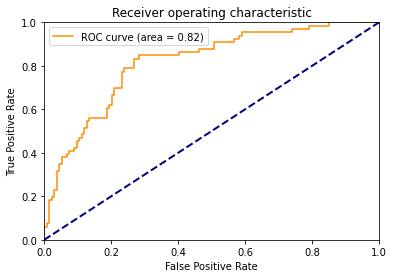

Cross Validation Accuracy: 0.73 (+/- 0.05)
Cross Validation Precision: 0.54 (+/- 0.06)
Cross Validation Recall: 0.73 (+/- 0.06)
Cross Validation f1_score: 0.62 (+/- 0.05)
Cross Validation roc_auc: 0.62 (+/- 0.04)
CV Score: 0.68 (+/- 0.05)
------RandomForestClassifier--------
f2 score : 0.5727554179566563
[[112  22]
 [ 29  37]]
Accuracy: 0.745
Recall: 0.745
Precision: 0.745
F1-score: 0.7032727272727273


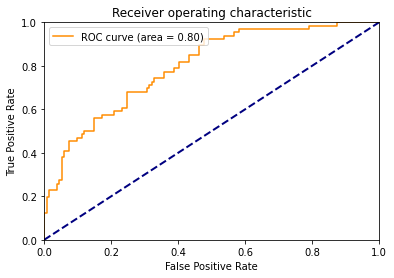

Cross Validation Accuracy: 0.77 (+/- 0.03)
Cross Validation Precision: 0.62 (+/- 0.07)
Cross Validation Recall: 0.58 (+/- 0.07)
Cross Validation f1_score: 0.60 (+/- 0.06)
Cross Validation roc_auc: 0.60 (+/- 0.04)
CV Score: 0.59 (+/- 0.06)


"\nprint('------XGBClassifier--------')\nparams={'n_estimators':3000,'objective': 'binary:logistic','learning_rate': 0.05, 'gamma':0.1, 'subsample':0.8,           'colsample_bytree':0.3, 'min_child_weight':3, 'max_depth':3,'n_jobs' : -1 }\nxgb = XGBClassifier(**params)\nxgb.fit(X_train, y_train)\nf2_measure(xgb,X_test, y_test)\nget_result(xgb,y_test,X_test)\nget_eval1(xgb,X,y,10)\n\n"

In [28]:
# Engineed Model Output
# Logistic regression classifier
print('------Logistic regression--------')
clf = LogisticRegression(penalty='l2',C=1.0, max_iter=10000,solver='liblinear', class_weight='balanced')
clf.fit(X_train, y_train)
f2_measure(clf,X_test, y_test)
get_result(clf,y_test,X_test)
get_eval1(clf,X,y,10)

print('------RandomForestClassifier--------')
from sklearn.ensemble import RandomForestClassifier
rfparam={'max_features':'auto','n_estimators': 400,'random_state':42,'max_depth':9,'oob_score':True,\
         'class_weight':'balanced', 'n_jobs':-1}
rf = RandomForestClassifier(**rfparam)
rf.fit(X_train, y_train)
f2_measure(rf,X_test, y_test)
get_result(rf,y_test,X_test)
get_eval1(rf,X,y,10)

'''
print('------XGBClassifier--------')
params={'n_estimators':3000,'objective': 'binary:logistic','learning_rate': 0.05, 'gamma':0.1, 'subsample':0.8,  \
         'colsample_bytree':0.3, 'min_child_weight':3, 'max_depth':3,'n_jobs' : -1 }
xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)
f2_measure(xgb,X_test, y_test)
get_result(xgb,y_test,X_test)
get_eval1(xgb,X,y,10)

'''
#Analysis : XGBoost no performing well on CV , LR is peforming better than other two

TRAIN: 750 TEST: 250
Accuracy: 0.768
Recall: 0.768
Precision: 0.768
F1-score: 0.6820175438596492


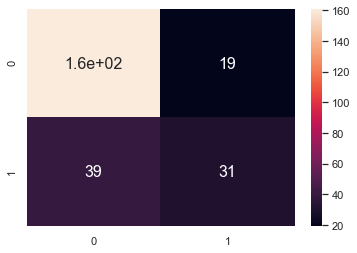

TRAIN: 750 TEST: 250
Accuracy: 0.792
Recall: 0.792
Precision: 0.792
F1-score: 0.7149122807017544


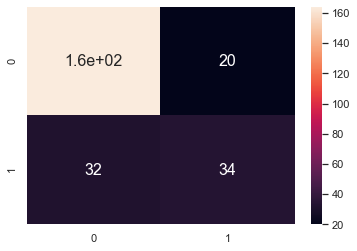

TRAIN: 750 TEST: 250
Accuracy: 0.696
Recall: 0.696
Precision: 0.696
F1-score: 0.6352886977886978


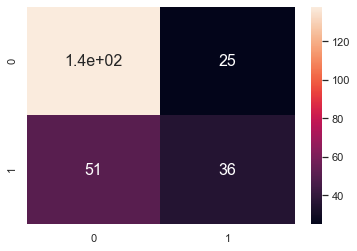

TRAIN: 750 TEST: 250
Accuracy: 0.748
Recall: 0.748
Precision: 0.748
F1-score: 0.6803652968036531


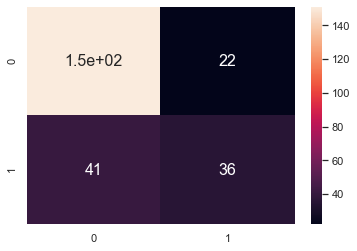

In [29]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

for train_index, test_index in kf.split(X):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = LogisticRegression(penalty='l2',C=1.0, max_iter=10000)
    # Train the classifier until max_iterations
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1}")
    
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
    sns.set(font_scale=1) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()

In [30]:
# Saving the model (to be used in API)
filename = 'model/finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
 